In [1]:
from pyALT import *
import pyALT.io as io
from scipy.stats import kendalltau
from scipy.stats import pearsonr
import pickle as pk
from PIL import Image
from matplotlib import pyplot as plt
from collections import namedtuple

In [2]:
fp = f'/Users/kshadi3/Dropbox/Constantine-Majid/Animal D - M022311/Masked data/Visual_deltaFn_Fn%.tif'

In [3]:
tif = vsd.load_tiff(fp)

In [4]:
mask = vsd.create_mask(tif,'Animal D - M022311')

In [2]:
G = io.load('meso_cortex.pk')

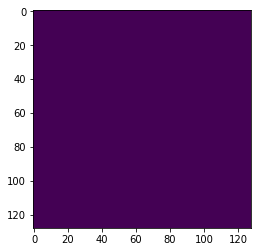

In [5]:
plt.imshow(mask)

In [6]:
vsd

<module 'pyALT.utils.vsd' from '/Users/kshadi3/Desktop/_a/Module/pyALT/utils/vsd.py'>

In [7]:
vsd_base = '/Users/kshadi3/Desktop/MAJID/'

In [8]:
L = ALT(G)
thresholds = {'VISp':4,'AUDp':1,'GU':2.5,'SSp-ul':2.5,'SSp-tr':2.5,
              'SSp-m':4,'SSp-bfd':4,'SSp-ll':1.5,'SSp-n':0.98,'MOB':0.46}
srcs = ['SSp-n','AUDp','VISp','GU','SSp-ul','SSp-tr','SSp-m','SSp-bfd','SSp-ll','MOB']
for src in srcs:
    L.add_source(src)
    L.set_theta(src,0.98)
L.set_theta('MOB',0.46)
L.run()
L.form_paths()
pc = L.path_centrality()
core = L.core()

In [9]:
core_nodes = [xx[0] for xx in core]

In [10]:
with open('info.pk','rb') as f:
    tx = pk.load(f)

In [11]:
import copy

In [12]:
tx.keys()

dict_keys(['rois', 'mapped_rois', 'T', 'landmarks', 'ex'])

In [13]:
np.array(tx['mapped_rois']['AUDp'],dtype='int8')

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

mask

33


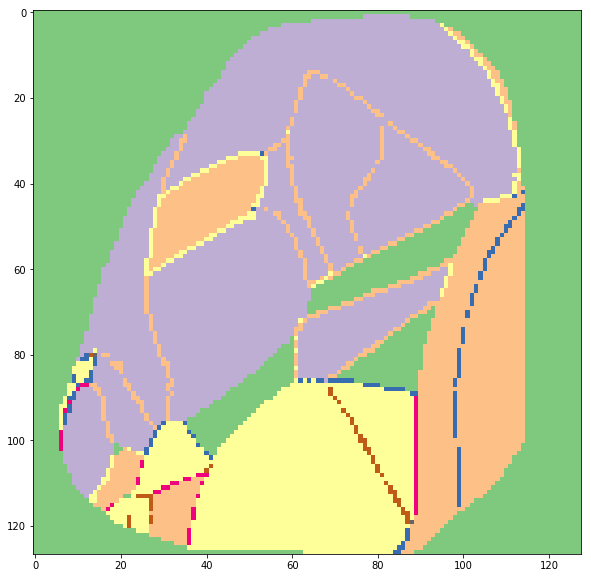

In [14]:
m = copy.deepcopy(mask)
for i,k in enumerate(tx['mapped_rois']):
    r = np.random.randint(2,15)
    m +=  (r)*np.array(tx['mapped_rois'][k],dtype='int8')
m[mask==0] = -1
print(np.max(m))
fig= plt.figure(figsize=(10,10))
plt.imshow(m,cmap='Accent')

In [15]:
sensor = 'Visual'
with open(f'a1-{sensor}-4.pk','rb') as f:
    experiment = pk.load(f)

In [16]:
m,n = mask.shape
vsd = np.zeros((m,n))
s = set([])
for i in range(m):
    for j in range(n):
        try:
            x = experiment[(i,j)].peak_time
            vsd[i][j] = x
            s.add(x)
        except KeyError:
            pass

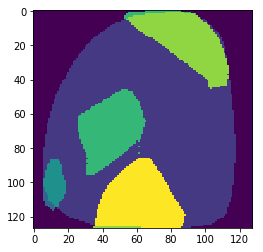

In [17]:
plt.imshow(mask+5*tx['mapped_rois']['VISp']+4*tx['mapped_rois']['MOp']+3*tx['mapped_rois']['SSp-bfd']+2*tx['mapped_rois']['AUDp'])

In [18]:
from collections import Counter

In [19]:
res = {}
res[sensor] = defaultdict(list)
for w in tx['mapped_rois']:
    if w in tx['ex']:continue
    roi = tx['mapped_rois'][w]
    for i in range(m):
        for j in range(n):
            if roi[i][j]<1:continue
            tmp = vsd[i,j]
            if tmp>=31:
                res[sensor][w] += [tmp]

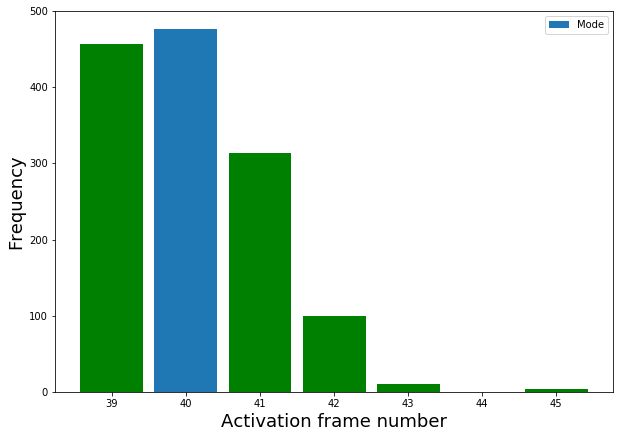

In [20]:
o = res[sensor]['MOp']
med = np.median(o)
mo = int(min(o))
mx = int(max(o)+1)
xs = []
ys = []
for i in range(mo,mx):
    xs.append(i)
    ys.append(o.count(i))
fig = plt.figure(figsize=(10,7))                                                               
ax = fig.gca()  #get current axes
ax.bar(xs[0], ys[0], .85, align='center',color='green')
ax.bar(xs[1], ys[1], .85, align='center',label='Mode')
ax.bar(xs[2:], ys[2:], .85, align='center',color='green')
# ax.axvline(med,ls='dashed',lw=2,color='red',label='Median')
plt.xlabel('Activation frame number',fontsize=18)
plt.ylabel('Frequency',fontsize=18)
# plt.title('MOp pixel activation time distribution - '+sensor,fontsize=18)
plt.legend()

In [21]:
res.keys()

dict_keys(['Visual'])

In [22]:
def dist_break(x):
    out = []
    N = np.sum([xx[1] for xx in x])
    out.append((x[0][0],x[0][1]*100/N))
    x = sorted(x,key=lambda x:x[0])
    q = 0
    a5 = int(N*.05)
    a50 = int(N*.5)
    a5_set = False
    a50_set = False
    for w in x:
        q+=w[1]
        if q>=a5 and not a5_set:
            out.append(w[0])
            a5_set = True
        if q>=a50 and not a50_set:
            out.append(w[0])
            a50_set = True
        if a5_set and a50_set:break
    return out

In [23]:
res.keys()

dict_keys(['Visual'])

In [24]:
Majid = namedtuple('Majid','roi init med mode freq')
S = {}
print('ROI, 5-percentile,Median, Mode, Mode Freq.')
for w in res[sensor]:
    cur = res[sensor][w]
    c = Counter(cur)
    tmp = sorted([(x,c[x]) for x in c],reverse=True,key = lambda x:x[1])
    y = dist_break(tmp)
    st = f'{w},{int(y[1])},{int(y[2])},{int(y[0][0])},{int(y[0][1])}'
    S[w] = Majid(roi=w,init=y[1],med=y[2],mode=y[0][0],freq =y[0][1])

ROI, 5-percentile,Median, Mode, Mode Freq.


In [25]:
majid2roi = {'Tone':'AUDp','Visual':'VISp','Hindlimb':'SSp-ll','Formlimb':'SSp-ul','Whisker':'SSp-bfd'}
adag = L(majid2roi[sensor])
Z = {}
tmp = [xx.med for xx in S.values()]
mm = min(tmp)
mx = max(tmp)
for w in S:
    roi = S[w].roi
    Z[roi] = adag.node[roi]['activation_time']
tmp = [xx for xx in Z.values()]
zm = min(tmp)
zx = max(tmp)
for w in S:
    roi = S[w].roi
    Z[roi] = mm+(mx-mm)*adag.node[roi]['activation_time']/zx
    Z[roi] = int(round(Z[roi]))

In [26]:
def printPHD(PHD):
    print('VSD/ALT,a>b,a=b,a<b')
    di = np.sum(np.diag(PHD))
    a = np.sum(PHD)
    gold = di/(a)
    bad = (PHD[0,2]+PHD[2,0])/a
    for i in range(3):
        h='a>b' if i==0 else ('a=b' if i==1 else 'a<b')
        print(h+','+','.join([str(np.ceil(xx)) for xx in PHD[i]]))
    print(',,'+str(round(gold*100))+'%,'+str(round(bad*100))+'%')
def measure(t1,t2,_t1,_t2):
    if t1>t2:
        if _t1>_t2:
            return (0,0)
        elif _t1==_t2:
            return (0,1)
        else:
            return (0,2)
    elif t1==t2:
        if _t1>_t2:
            return (1,0)
        elif _t1==_t2:
            return (1,1)
        else:
            return (1,2)
    else:
        if _t1>_t2:
            return (2,0)
        elif _t1==_t2:
            return (2,1)
        else:
            return (2,2)
PHD = np.zeros((3,3))
key = list(Z.keys())
l = len(key)
for i in range(l-1):
    for j in range(i+1,l):
        k1 = key[i]
        k2 = key[j]
        t1 = Z[k1]
        t2 = Z[k2]
        _t1 = S[k1].med
        _t2 = S[k2].med
#         _t1 = rs[k1]
#         _t2 = rs[k2]
        u,v = measure(t1,t2,_t1,_t2)
        PHD[u,v] +=1
printPHD(PHD)

VSD/ALT,a>b,a=b,a<b
a>b,69.0,25.0,6.0
a=b,11.0,15.0,18.0
a<b,4.0,19.0,43.0
,,60.0%,5.0%


In [27]:
def randomize(S):
    tmp = list(S.items())
    out = {}
    for k,majid in tmp:
        out[k] = majid.init
    l = len(tmp)
    for i,val in enumerate(tmp):
        roi,majid = val
        while True:
            j = np.random.randint(0,l)
            sw = tmp[j][1]
            if majid.init != sw.init:
                break
        out[tmp[i][0]] = tmp[j][1].init
        out[tmp[j][0]] = tmp[i][1].init
    return out
rs = randomize(S)

In [28]:
Point = namedtuple('Point', 'x y')
pt1 = Point(1.0, 5.0)
pt2 = Point(2.5, 1.5)
pt1.x

1.0

In [29]:
def plot(m1,m2,ax=None,ylabel=None,text=True):
    if ax is None:
        fig,ax = plt.subplots(figsize=(5,5))
    d1 = dict(m1)
    d2 = dict(m2)
    
    vec1 = []
    vec2 = []
    for w in d1:
        v1 = d1[w]
        v2 = d2[w]
        if w in core_nodes:
            ax.plot(v1,v2,'r*',ms=8)
#         elif w in s5:
#             ax.plot(v1,v2,'kd',ms=8)
        else:
            ax.plot(v1,v2,'bs',ms=6)
        vec1.append(v1)
        vec2.append(v2)
    k,_ = kendalltau(vec1,vec2)
    y = .9*np.max(vec2)
    if text:
        ax.text(.15,y,r'kendall $\tau$='+f'{k:.3f}')
    p,_ = pearsonr(vec1,vec2)
    ax.set_xlim(left=-0.01)
    ax.set_ylim(bottom=-0.01)
    if ylabel:
        ax.set_ylabel(ylabel,fontsize=18)
    return (k,p)

NameError: name 'so' is not defined

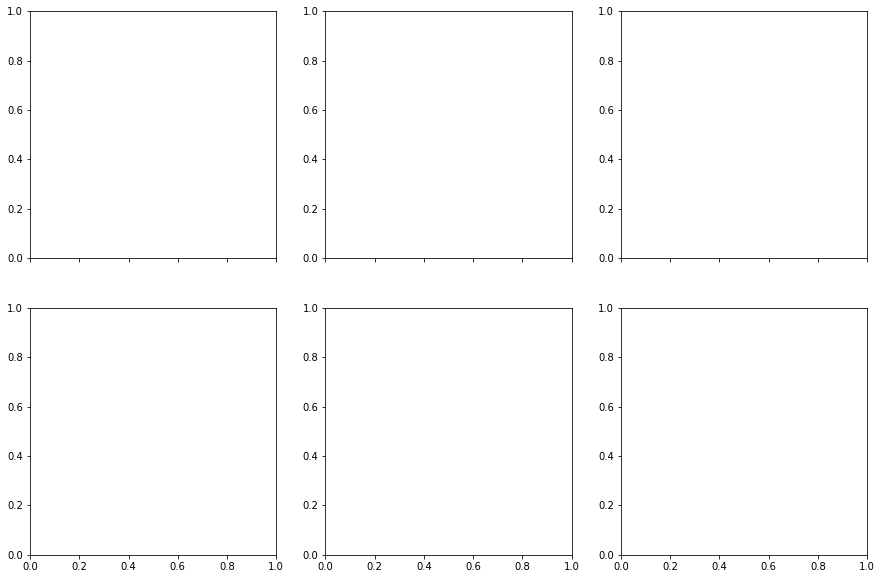

In [30]:
fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(15,10),sharex=True)
mets = [(so,si,'Strength','out-strength','in-strength'),(bc,cn,'shortest path','betweenness','closeness')
        ,(pr,ev,'spectral','pagerank','eigen')]
for i,w in enumerate(mets):
    k,p = plot(pc,w[0],ax[0,i],w[3])
    kw,pw = plot(pc,w[1],ax[1,i],w[4])
    ax[0,i].set_title(w[2],fontsize=18)
    st = f'Kendall {k:.3f}'
    stw = f'Kendall {kw:.3f}'


ax[1,0].set_xlabel('Path centrality',fontsize=18)
ax[1,1].set_xlabel('Path centrality',fontsize=18)
ax[1,2].set_xlabel('Path centrality',fontsize=18)
plt.tight_layout()

In [30]:
st = 'Centrality metric, Top 5 nodes'
r = ['Out-strength','In-strength','Betweenness','Closeness','Eigen','Pagerank']
for i,w in enumerate([so,si,bc,cn,ev,pr]):
    st = st + '\n' + r[i] + ' , ' +' - '.join([xx[0] for xx in w[0:5]])

In [31]:
print(st)

Centrality metric, Top 5 nodes
Out-strength , ENTl - CA2 - PIR - FRP - EPv
In-strength , CA1 - MOs - ENTl - DP - FRP
Betweenness , ENTl - CLA - PERI - VISl - MOs
Closeness , ENTl - PERI - CLA - PIR - VISl
Eigen , MOs - FRP - AOB - CLA - MOp
Pagerank , VISl - RSPagl - VISpm - FRP - RSPv


Text(0.5,0,'Path centrality')

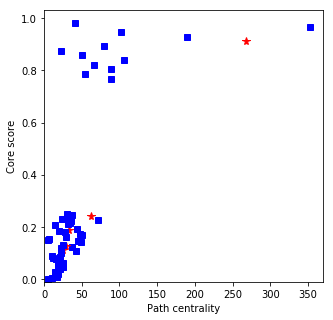

In [23]:
import cpalgorithm as cpa
rb = cpa.Rombach()
rb.detect(G)
a = rb.get_coreness()
rb = cpa.Rombach()
rb.detect(G)
b = rb.get_coreness()
# a = nx.core_number(G)
plot(si,process_metric(a,ex),text=False)
plt.ylabel('Core score')
plt.xlabel('Path centrality')

In [20]:
import numpy as np

pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])
unpad = lambda x: x[:,:-1]

def get_affine_transform(primary,secondary):

    # Pad the data with ones, so that our transformation can do translations too
    n = primary.shape[0]

    X = pad(primary)
    Y = pad(secondary)

    # Solve the least squares problem X * A = Y
    # to find our transformation matrix A
    A, res, rank, s = np.linalg.lstsq(X, Y)


    A[np.abs(A) < 1e-10] = 0 # set really small values to zero
    return A

def apply_affine(A,x):
    transform = lambda x: unpad(np.dot(pad(x), A))
    return transform(x)

In [24]:
tx = 2
ty = -1
primary = np.array([[1, 1],
                    [0, 0],
                    [2, 0]])

secondary = np.array([[-2+tx, 2+ty],
                    [0+tx, 0+ty],
                    [0+tx, 4+ty]])
test = np.array([[1,-3]])
A = get_affine_transform(primary,secondary)
apply_affine(A,test)

/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  app.launch_new_instance()


array([[8., 1.]])